### Testing Simulations

In [121]:
# imports
import numpy as np
import pandas as pd
import numpy.ma as ma
import importlib
import matplotlib
from astropy.stats import sigma_clipped_stats
from importlib import reload
import time
from astropy.io import fits
import re

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

#personal
from pipeline.est_pipeline import *
from pipeline.code.file_reader import *
from pipeline.code.corr_plots import *
from pipeline.code.cluster import *

import pipeline.code.Estimator as es
import pipeline.code.Estimator_R as er
import pipeline.code.data_table as d_t
import pipeline.code.graph_code as gc
import pipeline.code.Correlator as Cor

import t_const_code as tc

In [82]:
import test_sim as ts

## Part 1: Correlations of simulated data

In [83]:
## First find files
#ehu:/data/emcewen/sim/2021110[1,2]/simul.YYYYMMDD.aocb.fits files.

# Out directory specific for this test
out_dir = "/home/emcewen/test_simul/"
data_path = "/home/imaka/data/"
target_path = "home/imaka_wfp/inputs/targets/"

file1 = '/data/emcewen/sim/20211101/simul.20211101_203350.aocb.fits'
name1 = 'simul.20211101_203350'
file2 = '/data/emcewen/sim/20211102/simul.20211102_105221.aocb.fits'
name2 = 'simul.20211102_105221'

In [ ]:
### ADDING PLOTTING TO test_simul.py

In [11]:
fits.open(file1)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fb33533e940>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fb3352f85f8>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fb3352f8fd0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fb3352fe898>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fb3352fefd0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fb335303898>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fb335307198>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fb335307828>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fb335307ef0>]

In [19]:
cor1 = ts.calc_par(name1, file1, 1000)

Starting parallel ACor
... Finished in  605.284684419632
Starting parallel XCor
... Finished in  1178.195510149002
Writing Fits File
... Finished in  0.4460132122039795


In [17]:
cor2 = ts.calc_par(name2, file2, 200)

Starting parallel ACor
... Finished in  98.81811690330505
Starting parallel XCor
... Finished in  227.36476039886475
Writing Fits File
... Finished in  0.2593865394592285


### 1.1 Displaying Correlations

Q: why are they flipping??

In [122]:
reload(Cor)
home_dir = "/home/emcewen/"

file_s2_1 = home_dir + "test_simul/fits/simul.20211118_143311_tmax1000_tts.fits"
file_s2_2 = home_dir + "test_simul/fits/simul.20211118_144811_tmax1000_tts.fits"
# raw
file_s2_1r = home_dir + "test_simul/fits/simul.20211118_143311_tmax1000_raw.fits"
file_s2_2r = home_dir + "test_simul/fits/simul.20211118_144811_tmax1000_raw.fits"
# limit range
file_s2_1r_1024 = home_dir + "test_simul/fits/simul.20211118_143311_tmax500_raw_f0_1024.fits"
file_s2_2r_1024 = home_dir + "test_simul/fits/simul.20211118_144811_tmax500_raw_f0_1024.fits"

In [123]:
p_file = file_s2_1
corr_data = Cor.Correlator("", "", "", f_file=p_file)

In [94]:
## PLOTTING: Default Display covariance movie
corr_data.cor_animate_all(40, avg_sub=False, avg_len=1000) 

'/home/emcewen/test_simul/plots/ccor_all_gif/simul.20211118_144811_raw_ccor_all_1.gif'

In [129]:
## PLOTING: manual
wfs = 0

data_cx, data_cy = corr_data.data_get_cc_f_all( med_sub=False, avg_sub=False, avg_len=1000)
frames = (data_cx+data_cy)[0,0] / 2

#data_cx, data_cy = corr_data.ccor_x[wfs][wfs], corr_data.ccor_y[wfs][wfs]
#frames = (data_cx+data_cy)/ 2

#gif_ccor_mat((data_cx+data_cy), dt_max, title, out_file)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Change me
#######
gif_len = 50
#######
fig = plt.figure()
ax = fig.add_subplot(111)

# I like to position my colorbars this way, but you don't have to
div = make_axes_locatable(ax)
cax1 = div.append_axes('right', '5%', '5%')

cv0 = frames[0]
im = ax.imshow(cv0, origin='lower') # Here make an AxesImage rather than contour
cb1 = fig.colorbar(im, cax=cax1)
tx = ax.set_title('Frame 0')

vstd = np.median(np.std(frames[:gif_len], axis=(1,2)))
vmax = +vstd*3
vmin = -vstd*3

def animate(i):
    arr = frames[i]
    #vmax     = np.max(arr)
    #vmin     = np.min(arr)
    im.set_data(arr)
    im.set_clim(vmin, vmax)
    tx.set_text(f'{corr_data.name} Frame {i}')
    # In this version you don't have to do anything to the colorbar,
    # it updates itself when the mappable it watches (im) changes

ani = animation.FuncAnimation(fig, animate, frames=gif_len)

plt.show()
out_file = f"{corr_data.name}_anicorr.gif"
ani.save(out_file, writer = 'imagemagick')

In [79]:
# PLOT: background and correlation side by side

def gif_two_cb(data1, data2, title, out_file):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
    plt.setp(axes, xticks=[], yticks=[]) # turn off tick marks

    div1 = make_axes_locatable(axes[0])
    cax1 = div1.append_axes('right', '5%', '5%')
    div2 = make_axes_locatable(axes[-1])
    cax2 = div2.append_axes('right', '5%', '5%')

    # This is now a list of arrays rather than a list of artists
    frames = (data_cx+data_cy)[0,0]
    d1_0 = data1[0]
    d2_0 = data2[0]

    im1 = axes[0].imshow(d1_0, origin='lower') # Here make an AxesImage rather than contour
    im2 = axes[1].imshow(d2_0, origin='lower')
    cb1 = fig.colorbar(im1, cax=cax1)
    cb2 = fig.colorbar(im2, cax=cax2)
    tx = fig.suptitle(f'{title} Step 0')

    vstd1 = np.median(np.std(data1, axis=(1,2)))
    vstd2 = np.median(np.std(data2, axis=(1,2)))
    fig.tight_layout()

    def animate(i):
        im1.set_data(data1[i])
        im1.set_clim(-vstd1, +vstd1)
        im2.set_data(data2[i])
        im2.set_clim(-vstd2, +vstd2)
        tx.set_text(f'{title} Step {i}')

    ani = animation.FuncAnimation(fig, animate, frames=10)
    ani.save(out_file, writer = 'imagemagick')

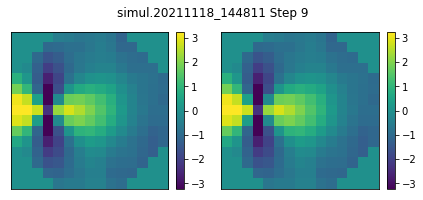

In [80]:
gif_two_cb((data_cx+data_cy)[0,0], (data_cx+data_cy)[0,0], corr_data.name, "test_three.gif")

In [ ]:
def Bcakground_map(avg_wf):
    #detect_lvl = np.zeros_like(avg_wfs)
    t_mean = np.zeros_like(avg_wf)
    t_stdev = np.zeros_like(avg_wf)

    for t in range(avg_wf.shape[0]):
        # 1.1.  For each pixel in the cov map assign a radius
        t_slice = avg_wf[t]
        sigma = 3
        # 1.2. find the mean (m) and stddev (sd) of the pixels 
        # in a radial annuli one pixel wide (r from 1 to 7 +/- 0.5.  
        # I do a sigma clipping on this with a clip=3 si
        for r in np.arange(8):
            rad_vals = np.multiply(t_slice, rad_map_boolean[r])
            mean, median, std = sigma_clipped_stats(rad_vals, sigma=sigma, mask=rad_map_inv[r])
            # TRY REDOING MASKING => try to flatten?
            #print(t, r, mean, std)
            t_mean[t] = t_mean[t] + mean*rad_map_boolean[r]
            t_stdev[t] = t_stdev[t] + std*rad_map_boolean[r]
    # 1.3. For each pixel I assign a "detection level in sigma over the mean"
    # = (im[x,y] - m)/sd.   
    # This results in a detection map for each cov map time slice. 
    detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
    return detect_map

In [ ]:
# Triangular matricies

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure()
ax = fig.add_subplot(111)

# I like to position my colorbars this way, but you don't have to
div = make_axes_locatable(ax)
cax1 = div.append_axes('right', '5%', '5%')
#cax2 = div.append_axes('left', '5%', '5%')

# This is now a list of arrays rather than a list of artists
frames = (data_cx+data_cy)[0,0]

cv0 = frames[0]
im = ax.imshow(cv0, origin='lower') # Here make an AxesImage rather than contour
cb1 = fig.colorbar(im, cax=cax1)
#cb2 = fig.colorbar(im, cax=cax2, 'AxisLocation','out')
tx = ax.set_title('Frame 0')

vstd = vstd = np.median(np.std(frames, axis=(1,2)))
vmax = +vstd
vmin = -vstd

def animate(i):
    arr = frames[i]
    #vmax     = np.max(arr)
    #vmin     = np.min(arr)
    im.set_data(arr)
    im.set_clim(vmin, vmax)
    tx.set_text(f'{corr_data.name} Frame {i}')
    # In this version you don't have to do anything to the colorbar,
    # it updates itself when the mappable it watches (im) changes

ani = animation.FuncAnimation(fig, animate, frames=50)

plt.show()
out_file = "test.gif"
ani.save(out_file, writer = 'imagemagick')


def gif_ccor_mat(mat_arr, tmax, title=None, out_file='out.gif'):
    min_val = np.min(mat_arr, axis=(0, 1, 3, 4))
    max_val = np.max(mat_arr, axis=(0, 1, 3, 4))
    n_len, n_width = mat_arr.shape[0], mat_arr.shape[1] 
    fig, axes = plt.subplots(nrows=n_len, ncols=n_width, figsize=(2*n_len,2*n_width))
    fig.subplots_adjust(wspace=0.3)
    fig.suptitle(str(title))
    # setup
    for i in range(n_len):
            for j in range(n_width):
                if i>=j:
                    ax = axes[i][j]
                    ax.set_xlabel("WFS" + str(i) + " WFS"+ str(j))  
                    ax.set_xticklabels([])
                    ax.set_yticklabels([])
                    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
                    ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
                else:
                    axes[i, j].remove()
                    
    def animate(i):
        arr = frames[i]
        for i in range(n_len):
            for j in range(n_width):
                if i>=j:
                    ax = axes[i][j]
                    im = ax.matshow(mat_arr[i][j][t], vmin = min_val[t], vmax=max_val[t])
        
        #vmax     = np.max(arr)
        #vmin     = np.min(arr)
        im.set_data(arr)
        im.set_clim(vmin, vmax)
        tx.set_text(f'{corr_data.name} Frame {i}')
        # In this version you don't have to do anything to the colorbar,
        # it updates itself when the mappable it watches (im) changes
    
    
    #animate
    camera = Camera(fig)
    for t in range(tmax):
        for i in range(n_len):
            for j in range(n_width):
                if i>=j:
                    ax = axes[i][j]
                    im = ax.matshow(mat_arr[i][j][t], vmin = min_val[t], vmax=max_val[t])
                    #im = ax.matshow(mat_arr[i][j][t])
                    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
                    ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
                if i==0 and j==0:
                    ax.text(0, 1.1," t = " + str(t), transform=ax.transAxes)
        #fig.tight_layout()
        camera.snap()
    animation = camera.animate()  
    animation.save(out_file, writer = 'imagemagick')

In [ ]:
    def cor_animate_all(self, dt_max = 30, med_sub=False, avg_sub=False, avg_len=10):
        # check to see if data is valid
        if self.data_valid and not self.ccor:
            logging.warning("Cross corr not available, generating")
            self.ccor_gen()
        elif not self.data_valid:
            logging.error("Data not available") 
            return None
        # Retrieve data for graphing
        if dt_max > self.tmax: dt_max = self.tmax
        #data_cx, data_cy = self.data_get_cc_all(med_sub, avg_sub, avg_len)
        data_cx, data_cy = self.data_get_cc_f_all(med_sub, avg_sub, avg_len)
        # Plot title and file
        title = self.plot_title_gen(" Cross Corr, all WFS", med_sub, avg_sub, avg_len)
        out_file = self.plot_file_gen("ccor_all_gif", "_ccor_all", "gif", med_sub, avg_sub, avg_len) 
        # animate all correlations 
        try:
            logging.debug("Graphing: cor_animate_all")
            gif_ccor_mat((data_cx+data_cy), dt_max, title, out_file)
            plt.close("all")
            return out_file
        except Exception as e:
            logging.error("Error in gif_ccor_mat: %s"% e)
            return False

### 1.2 Displaying Decays

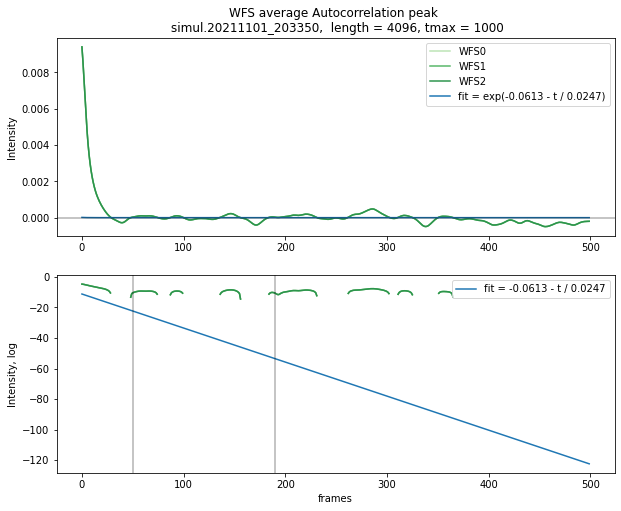

In [24]:
## decay curve
p_file = "/home/emcewen/test_simul/fits/simul.20211101_203350_tmax200_tts.fits"
p_file = "/home/emcewen/test_simul/fits/simul.20211101_203350_tmax1000_tts.fits"

tmax_p = 500
tc.decay_plot(p_file, tmax_p, c_min = 50, c_max = 190)

In [ ]:
p_file = "/home/emcewen/test_simul/fits/simul.20211101_203350_tmax200_tts.fits"
decay_plot(p_file, tmax_p, c_min = 50, c_max = 190)

In [ ]:
# fit to the short term decays

### 1.3 Displaying Estimations

In [ ]:
data = Cor.Correlator("", "", "", f_file = p_file)

In [ ]:
er.est_file(p_file, plot = True)

In [ ]:
p_file = "/home/emcewen/test_simul/fits/simul.20211101_203350_tmax1000_tts.fits"
er.est_file(p_file, plot = True)

## Part 2: Adding to another clean file

In [ ]:
est_file(p_file)

## Part 3: Estimating wind speed